In [5]:
import pandas as pd
import glob
import holidays

# Generate US New York State holidays for 2023
ny_holidays = holidays.US(state='NY', years=2023)

# Function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# List to store all monthly data
all_data = []

# Read all monthly CSV files
for file in glob.glob("2023_Yellow_Taxi_Trip_Data_*.csv"):
    print(f"Processing {file}")
    
    df = pd.read_csv(file, low_memory=False)
    df = df[['tpep_dropoff_datetime', 'DOLocationID']]

    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
    df['hour'] = df['tpep_dropoff_datetime'].dt.hour
    df = df[(df['hour'] >= 7) & (df['hour'] < 22)]

    df['date'] = df['tpep_dropoff_datetime'].dt.date
    df['month'] = df['tpep_dropoff_datetime'].dt.month
    df['is_weekend'] = df['tpep_dropoff_datetime'].dt.weekday >= 5
    df['season'] = df['month'].apply(get_season)
    df['is_holiday'] = df['date'].apply(lambda x: x in ny_holidays)

    all_data.append(df)

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)

# Group by relevant features and count drop-offs
dropoff_stats = df_all.groupby(['DOLocationID', 'hour', 'is_weekend', 'season', 'is_holiday']).size().reset_index(name='dropoff_count')

# Save output
dropoff_stats.to_csv("zone_hour_dropoff_2023_full.csv", index=False)

print("Data processing completed. Output saved as zone_hour_dropoff_2023_full.csv.")


Processing 2023_Yellow_Taxi_Trip_Data_Apr2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Aug2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Dec2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Feb2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Jan2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Jul2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Jun2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Mar2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_May2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Nov2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Oct2023.csv
Processing 2023_Yellow_Taxi_Trip_Data_Sep2023.csv
Data processing completed. Output saved as zone_hour_dropoff_2023_full.csv.


In [6]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import glob
import holidays

# Generate US New York State holidays for 2023
ny_holidays = holidays.US(state='NY', years=2023)

# Function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Load taxi zones shapefile
zones = gpd.read_file("taxi_zones/taxi_zones.shp").to_crs("EPSG:4326")

# List to store all monthly subway stats
all_subway_stats = []

# Loop over all monthly subway files
for file in glob.glob("MTA_Subway_*.csv"):
    print(f"Processing {file}")
    
    df = pd.read_csv(file)
    
    df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'], format='%m/%d/%Y %I:%M:%S %p')
    df['hour'] = df['transit_timestamp'].dt.hour
    df = df[(df['hour'] >= 7) & (df['hour'] < 22)]

    df['date'] = df['transit_timestamp'].dt.date
    df['month'] = df['transit_timestamp'].dt.month
    df['is_weekend'] = df['transit_timestamp'].dt.weekday >= 5
    df['season'] = df['month'].apply(get_season)
    df['is_holiday'] = df['date'].apply(lambda x: x in ny_holidays)

    # Convert to GeoDataFrame
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    gdf_subway = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

    # Spatial join with zones
    gdf_joined = gpd.sjoin(gdf_subway, zones[['geometry', 'LocationID']], how='left', predicate='within')

    # Group and aggregate
    subway_stats = gdf_joined.groupby(['LocationID', 'hour', 'is_weekend', 'season', 'is_holiday'])['ridership'].sum().reset_index()
    subway_stats.rename(columns={'ridership': 'total_ridership'}, inplace=True)

    all_subway_stats.append(subway_stats)

# Combine all months
df_all_subway = pd.concat(all_subway_stats, ignore_index=True)

# Save final output
df_all_subway.to_csv("zone_hour_subway_2023_full.csv", index=False)

print("Subway data processing completed. Output saved as zone_hour_subway_2023_full.csv.")


Processing MTA_Subway_April.csv
Processing MTA_Subway_Aug.csv
Processing MTA_Subway_Dec.csv
Processing MTA_Subway_Feb.csv
Processing MTA_Subway_Jan.csv
Processing MTA_Subway_July.csv
Processing MTA_Subway_June.csv
Processing MTA_Subway_March.csv
Processing MTA_Subway_May.csv
Processing MTA_Subway_Nov.csv
Processing MTA_Subway_Oct.csv
Processing MTA_Subway_Sep.csv
Subway data processing completed. Output saved as zone_hour_subway_2023_full.csv.


In [7]:
import pandas as pd

# Read drop-off and subway data (full year version)
dropoff_df = pd.read_csv("zone_hour_dropoff_2023_full.csv")
subway_df = pd.read_csv("zone_hour_subway_2023_full.csv")

# Rename to align fields
dropoff_df.rename(columns={'DOLocationID': 'LocationID'}, inplace=True)

# Merge based on expanded keys
merged = pd.merge(
    dropoff_df,
    subway_df,
    on=["LocationID", "hour", "is_weekend", "season", "is_holiday"],
    how="outer"
).fillna(0)

# Calculate busyness score
merged["busyness_score"] = merged["dropoff_count"] + merged["total_ridership"]

# Bin into 3 levels
merged["busyness_level"] = pd.qcut(merged["busyness_score"], q=3, labels=["low", "medium", "high"])

# Save result
merged.to_csv("zone_hour_busyness_labels_2023_full.csv", index=False)

print("Busyness label data generation completed.")


Busyness label data generation completed.


C:\Users\柯蕃\AppData\Local\Temp\ipykernel_19044\2202936101.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='busyness_level', data=df, order=['low', 'medium', 'high'], palette="Set2")


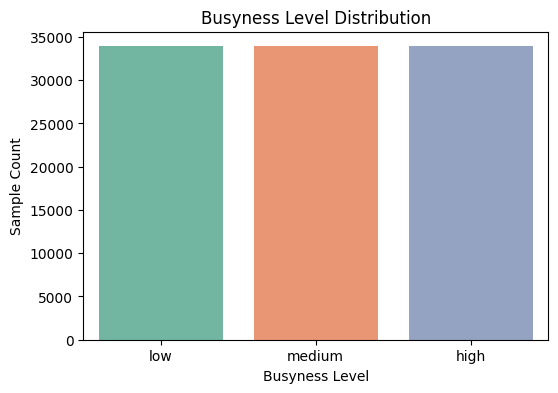

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("zone_hour_busyness_labels_2023_full.csv")

plt.figure(figsize=(6, 4))
sns.countplot(x='busyness_level', data=df, order=['low', 'medium', 'high'], palette="Set2")

plt.title("Busyness Level Distribution")
plt.xlabel("Busyness Level")
plt.ylabel("Sample Count")
plt.show()

c:\Anconda\envs\homework1py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:10:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


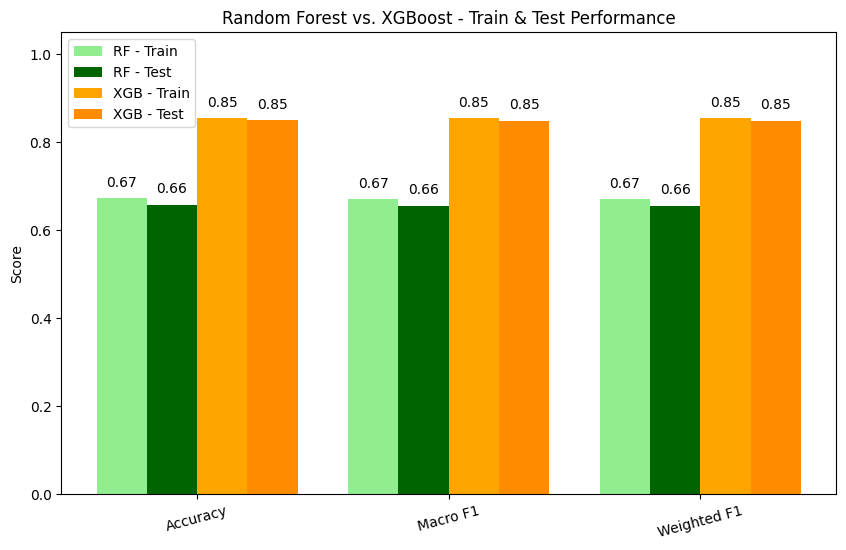

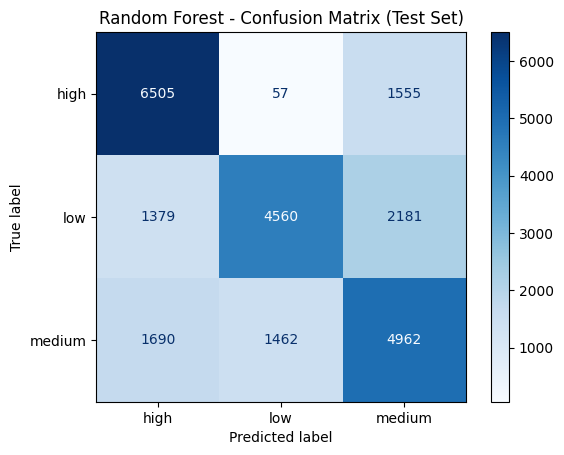

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Read labeled dataset
df = pd.read_csv("zone_hour_busyness_labels_2023_full.csv")

# Step 2: Prepare features
X = df[['LocationID', 'hour', 'is_weekend', 'season', 'is_holiday']].copy()
X['is_weekend'] = X['is_weekend'].astype(int)
X['is_holiday'] = X['is_holiday'].astype(int)

# Encode season (string to numeric)
season_encoder = LabelEncoder()
X['season'] = season_encoder.fit_transform(X['season'])

# Step 3: Prepare target
y = df['busyness_level']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Step 5: Model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
    return {
        "Train Accuracy": report_train['accuracy'],
        "Train Macro F1": report_train['macro avg']['f1-score'],
        "Train Weighted F1": report_train['weighted avg']['f1-score'],
        "Test Accuracy": report_test['accuracy'],
        "Test Macro F1": report_test['macro avg']['f1-score'],
        "Test Weighted F1": report_test['weighted avg']['f1-score'],
        "Test Predictions": y_pred_test  # For confusion matrix
    }

# Step 6: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_results = evaluate_model(rf, X_train, y_train, X_test, y_test)

# Step 7: Train XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=6, eval_metric='mlogloss', use_label_encoder=False)
xgb_results = evaluate_model(xgb, X_train, y_train, X_test, y_test)

# Step 8: Plot comparison bar chart
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

bars_rf_train = ax.bar(x - width*1.5, [rf_results[f"Train {m}"] for m in metrics], width, label='RF - Train', color="lightgreen")
bars_rf_test = ax.bar(x - width/2, [rf_results[f"Test {m}"] for m in metrics], width, label='RF - Test', color="darkgreen")
bars_xgb_train = ax.bar(x + width/2, [xgb_results[f"Train {m}"] for m in metrics], width, label='XGB - Train', color="orange")
bars_xgb_test = ax.bar(x + width*1.5, [xgb_results[f"Test {m}"] for m in metrics], width, label='XGB - Test', color="darkorange")

for bars in [bars_rf_train, bars_rf_test, bars_xgb_train, bars_xgb_test]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('Random Forest vs. XGBoost - Train & Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()

plt.show()

# Step 9: Optional - Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, rf_results["Test Predictions"])
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Random Forest - Confusion Matrix (Test Set)')
plt.show()


c:\Anconda\envs\homework1py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:00:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


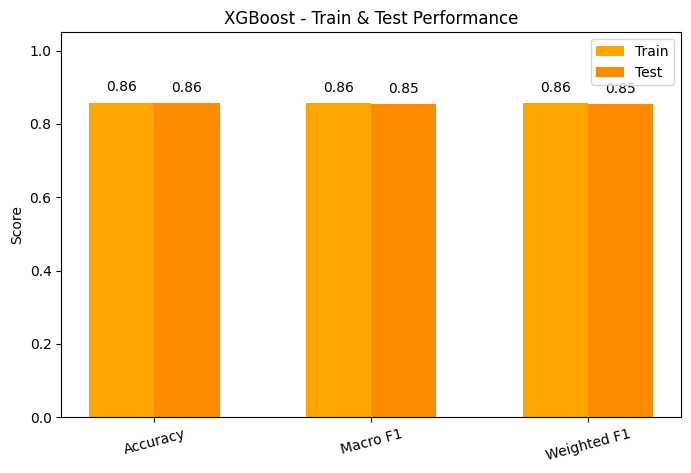

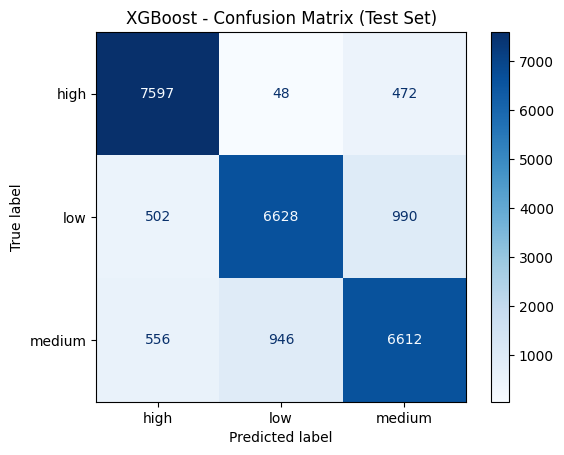

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: 读取数据
df = pd.read_csv("zone_hour_busyness_labels_2023_full.csv")

# Step 2: 特征准备
X = df[['LocationID', 'hour', 'is_weekend', 'season', 'is_holiday']].copy()
X['is_weekend'] = X['is_weekend'].astype(int)
X['is_holiday'] = X['is_holiday'].astype(int)

# 编码 season
season_encoder = LabelEncoder()
X['season'] = season_encoder.fit_transform(X['season'])

# Step 3: 目标变量
y = df['busyness_level']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: 训练测试划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Step 5: 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
    return {
        "Train Accuracy": report_train['accuracy'],
        "Train Macro F1": report_train['macro avg']['f1-score'],
        "Train Weighted F1": report_train['weighted avg']['f1-score'],
        "Test Accuracy": report_test['accuracy'],
        "Test Macro F1": report_test['macro avg']['f1-score'],
        "Test Weighted F1": report_test['weighted avg']['f1-score'],
        "Test Predictions": y_pred_test
    }

# Step 6: 改进版 XGBoost 模型
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Step 7: 评估 XGBoost
xgb_results = evaluate_model(xgb, X_train, y_train, X_test, y_test)

# Step 8: 结果展示
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))

bars_train = ax.bar(x - width/2, [xgb_results[f"Train {m}"] for m in metrics], width, label='Train', color="orange")
bars_test = ax.bar(x + width/2, [xgb_results[f"Test {m}"] for m in metrics], width, label='Test', color="darkorange")

# 添加数值标签
for bars in [bars_train, bars_test]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('XGBoost - Train & Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()
plt.show()

# Step 9: 混淆矩阵
cm = confusion_matrix(y_test, xgb_results["Test Predictions"])
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('XGBoost - Confusion Matrix (Test Set)')
plt.show()


c:\Anconda\envs\homework1py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:01:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


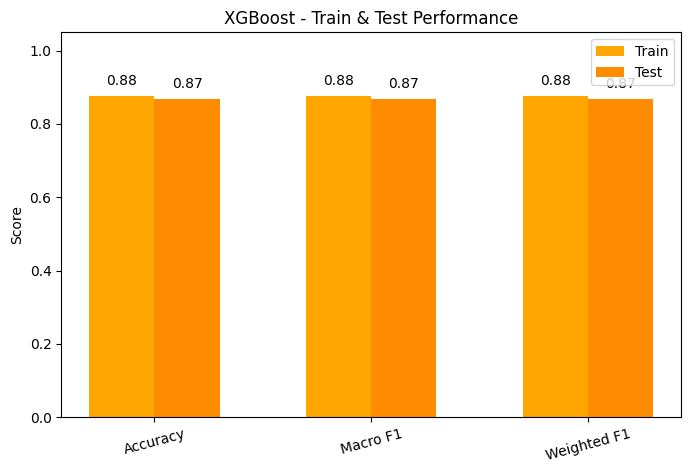

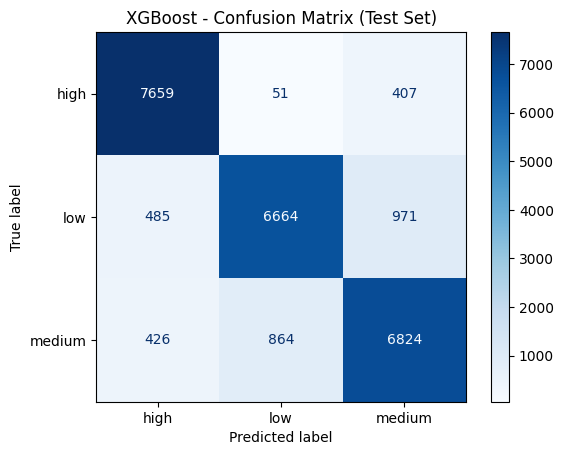

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: 读取数据
df = pd.read_csv("zone_hour_busyness_labels_2023_full.csv")

# Step 2: 特征准备
X = df[['LocationID', 'hour', 'is_weekend', 'season', 'is_holiday']].copy()
X['is_weekend'] = X['is_weekend'].astype(int)
X['is_holiday'] = X['is_holiday'].astype(int)

# 编码 season
season_encoder = LabelEncoder()
X['season'] = season_encoder.fit_transform(X['season'])

# Step 3: 目标变量
y = df['busyness_level']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: 训练测试划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Step 5: 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
    return {
        "Train Accuracy": report_train['accuracy'],
        "Train Macro F1": report_train['macro avg']['f1-score'],
        "Train Weighted F1": report_train['weighted avg']['f1-score'],
        "Test Accuracy": report_test['accuracy'],
        "Test Macro F1": report_test['macro avg']['f1-score'],
        "Test Weighted F1": report_test['weighted avg']['f1-score'],
        "Test Predictions": y_pred_test
    }

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)


# Step 7: 评估 XGBoost
xgb_results = evaluate_model(xgb, X_train, y_train, X_test, y_test)

# Step 8: 结果展示
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))

bars_train = ax.bar(x - width/2, [xgb_results[f"Train {m}"] for m in metrics], width, label='Train', color="orange")
bars_test = ax.bar(x + width/2, [xgb_results[f"Test {m}"] for m in metrics], width, label='Test', color="darkorange")

# 添加数值标签
for bars in [bars_train, bars_test]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('XGBoost - Train & Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()
plt.show()

# Step 9: 混淆矩阵
cm = confusion_matrix(y_test, xgb_results["Test Predictions"])
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('XGBoost - Confusion Matrix (Test Set)')
plt.show()

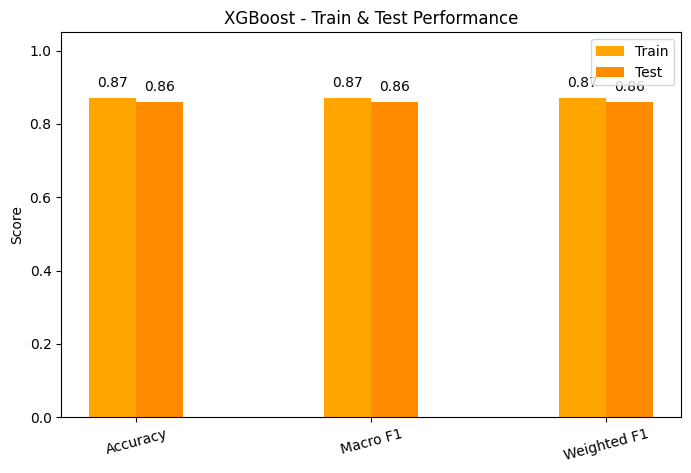

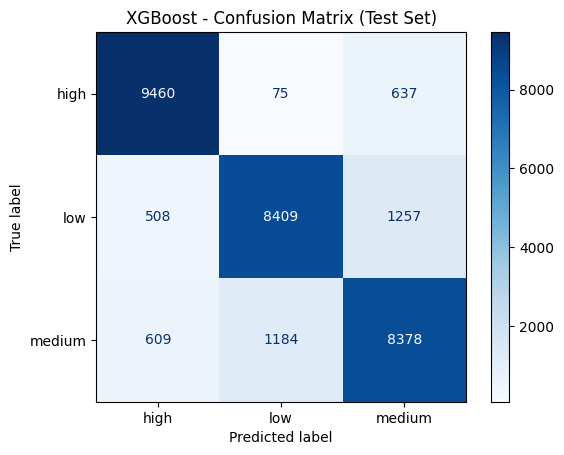

Model and encoders saved successfully.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Step 1: Read labeled dataset
df = pd.read_csv("zone_hour_busyness_labels_2023_full.csv")

# Step 2: Feature engineering
# Cyclical encoding of hour
num_hours = 24
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / num_hours)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / num_hours)

# Encode season
season_encoder = LabelEncoder()
df['season_encoded'] = season_encoder.fit_transform(df['season'])

# Prepare final feature set
X = df[['LocationID', 'hour_sin', 'hour_cos', 'is_weekend', 'season_encoded', 'is_holiday']].copy()
X['is_weekend'] = X['is_weekend'].astype(int)
X['is_holiday'] = X['is_holiday'].astype(int)

# Encode target
y = df['busyness_level']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Step 5: Model evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
    return {
        "Train Accuracy": report_train['accuracy'],
        "Train Macro F1": report_train['macro avg']['f1-score'],
        "Train Weighted F1": report_train['weighted avg']['f1-score'],
        "Test Accuracy": report_test['accuracy'],
        "Test Macro F1": report_test['macro avg']['f1-score'],
        "Test Weighted F1": report_test['weighted avg']['f1-score'],
        "Test Predictions": y_pred_test
    }

# Step 6: Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='mlogloss',
    random_state=42
)
xgb_results = evaluate_model(xgb, X_train, y_train, X_test, y_test)

# Step 7: Plot bar chart
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))

bars_train = ax.bar(x - width/2, [xgb_results[f"Train {m}"] for m in metrics], width, label='Train', color="orange")
bars_test = ax.bar(x + width/2, [xgb_results[f"Test {m}"] for m in metrics], width, label='Test', color="darkorange")

for bars in [bars_train, bars_test]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('XGBoost - Train & Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()
plt.show()

# Step 8: Confusion Matrix
cm = confusion_matrix(y_test, xgb_results["Test Predictions"])
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('XGBoost - Confusion Matrix (Test Set)')
plt.show()

# Step 9: Save model and encoders
joblib.dump(xgb, "xgb_busyness_model.pkl")
joblib.dump(season_encoder, "season_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
np.save("label_classes.npy", label_encoder.classes_)

print("Model and encoders saved successfully.")
